***Используя PySpark, очистите, оцените и продемонстрируйте огромные данные в этом проекте. PySpark действительно является модулем Python, который позволяет вам общаться с помощью Apache Spark. Это отличается от Python в этой структуре данных Spark, которая зеркалируется, несмотря на то, что она позволяет создавать приложения Spark с использованием кода Python. Spark включает в себя ряд функций, таких как Spark SQL, а также библиотеку машинного обучения. Приложение Spark состоит из программного драйвера, который выполняет множество одновременных операций в кластере, в то время как основная цель пользователя выполняется. В этом проекте используются контролируемые алгоритмы машинного обучения, которые включают в себя сбор данных, их анализ, предварительную обработку, выбор лучшей модели, ее обучение и оценку. Прежде чем мы сможем работать с PySpark, мы должны сначала установить его и извлечь в систему. Для кодирования используется веб-приложение Google Colab Notebook. Необходимые библиотеки Python импортируются для запуска кода. Я попытался создать приложение двоичной классификации с помощью PySpark и API Pipelines библиотеки машинного обучения. Алгоритм логистической регрессии превосходит методы «Дерево решений», «Случайный лес» и «Дерево с градиентным усилением» в наборе данных.***

In [ ]:
#pip install pyspark

In [1]:
#Без этого костыля у меня не работал
import os
import sys

os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'

In [2]:
import pyspark

In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import desc
from pyspark.sql.functions import *
from pyspark.sql.functions import max as sparkMax

import pyspark.sql.functions as F

In [5]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'

spark.memory.fraction зарезервировано для пользовательских структур данных, внутренних метаданных в Spark и защиты от ошибок OOM в случае разреженных и необычно больших записей. <br>
spark.executor.memory Объем памяти, используемый каждым процессом-исполнителем <br>
spark.memory.offHeap.enabled Если задано значение true, Spark попытается использовать память вне кучи для определенных операций  <br>
spark.memory.offHeap.size бсолютный объем памяти, который можно использовать для выделения вне кучи, в байтах, если не указано иное. <br>
Подробнее [тут](https://spark.apache.org/docs/latest/configuration.html)

In [6]:
SparkSession \
  .builder \
  .master("local[*]")\
  .appName("Pyspark") \
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "8g") \
  .config("spark.driver.memory", "8g")\
  .config("spark.sql.shuffle.partitions" , "800") \
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","8g")\
  .getOrCreate()

In [7]:
#Creating a Spark session
mySpark = SparkSession.builder.getOrCreate()
spark = SparkSession(mySpark)

In [9]:
#importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

import warnings; warnings.filterwarnings(action='once')

In [20]:
#loading the dataset
data = spark.read.csv("bank-full.csv",inferSchema="true", header="true")

In [12]:
#Display of column name and data type
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- Target: string (nullable = true)



In [69]:
data.count()

45211

In [13]:
data.show(10)

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|Target|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown|    no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown|    no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown|    no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown|    no|
| 33|     unknown|  single|  unknown|     no|      1|     no| 

In [14]:
#Removal of rows & columns with NaN/Null values
data.dropna()

DataFrame[age: int, job: string, marital: string, education: string, default: string, balance: int, housing: string, loan: string, contact: string, day: int, month: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, Target: string]

In [22]:
data.show(10)

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|Target|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown|    no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown|    no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown|    no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown|    no|
| 33|     unknown|  single|  unknown|     no|      1|     no| 

In [23]:
data.count()

45211

In [24]:
#Removal of duplicate values
data.dropDuplicates()

DataFrame[age: int, job: string, marital: string, education: string, default: string, balance: int, housing: string, loan: string, contact: string, day: int, month: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, Target: string]

In [25]:
data.count()

45211

In [21]:
#check the null column count using sql
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(a) | col(a).isNull(), a)).alias(a) for a in data.columns]).show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|Target|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|     0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+



***Conversion of values to integer:
In the dataset there are some values which are Yes/No. For a proper data analysis these values a changed to 1/0.***

In [26]:
df = data

In [38]:
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|Target|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
| 58|  management| married| tertiary|      0|   2143|      1|   0|unknown|  5|  may|     261|       1|   -1|       0| unknown|     0|
| 44|  technician|  single|secondary|      0|     29|      1|   0|unknown|  5|  may|     151|       1|   -1|       0| unknown|     0|
| 33|entrepreneur| married|secondary|      0|      2|      1|   1|unknown|  5|  may|      76|       1|   -1|       0| unknown|     0|
| 47| blue-collar| married|  unknown|      0|   1506|      1|   0|unknown|  5|  may|      92|       1|   -1|       0| unknown|     0|
| 33|     unknown|  single|  unknown|      0|      1|      0| 

In [29]:
df = df.replace('yes','1')
df = df.replace('no','0')

In [30]:
df = df.withColumn("default",df.default.cast('integer'))
df = df.withColumn("loan",df.loan.cast('integer'))
df = df.withColumn("housing",df.housing.cast('integer'))
df = df.withColumn("Target",df.Target.cast('integer'))

In [31]:
#Display of column name and data type
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: integer (nullable = true)
 |-- loan: integer (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- Target: integer (nullable = true)



***Data Analysis: Сейчас мы проводим ряд анализов, чтобы узнать больше о характеристиках набора данных.
Результаты моновариантного и мультивариантного анализа представлены ниже***

In [32]:
data.groupBy("month").count().show()  

+-----+-----+
|month|count|
+-----+-----+
|  jul| 6895|
|  jun| 5341|
|  may|13766|
|  feb| 2649|
|  oct|  738|
|  sep|  579|
|  mar|  477|
|  apr| 2932|
|  dec|  214|
|  aug| 6247|
|  nov| 3970|
|  jan| 1403|
+-----+-----+



In [33]:
data.groupBy("job").count().show()  

+-------------+-----+
|          job|count|
+-------------+-----+
|      student|  938|
|       admin.| 5171|
|      unknown|  288|
| entrepreneur| 1487|
|    housemaid| 1240|
|   unemployed| 1303|
|      retired| 2264|
|     services| 4154|
|   management| 9458|
|self-employed| 1579|
|  blue-collar| 9732|
|   technician| 7597|
+-------------+-----+



In [34]:
data.groupBy("marital").count().show()  

+--------+-----+
| marital|count|
+--------+-----+
| married|27214|
|  single|12790|
|divorced| 5207|
+--------+-----+



In [35]:
data.groupBy("education").count().show()  

+---------+-----+
|education|count|
+---------+-----+
|secondary|23202|
|  unknown| 1857|
| tertiary|13301|
|  primary| 6851|
+---------+-----+



In [36]:
data.groupBy("housing").count().show()  

+-------+-----+
|housing|count|
+-------+-----+
|     no|20081|
|    yes|25130|
+-------+-----+



In [37]:
data.groupBy("loan").count().show()  

+----+-----+
|loan|count|
+----+-----+
|  no|37967|
| yes| 7244|
+----+-----+



In [29]:
data.groupBy("contact").count().show()  

+---------+-----+
|  contact|count|
+---------+-----+
|  unknown|13020|
| cellular|29285|
|telephone| 2906|
+---------+-----+



In [30]:
data.groupBy("campaign").count().show()  

+--------+-----+
|campaign|count|
+--------+-----+
|      28|   16|
|      44|    1|
|      16|   79|
|      17|   69|
|      23|   22|
|       7|  735|
|      38|    3|
|      14|   93|
|      18|   51|
|      12|  155|
|      35|    4|
|      55|    1|
|       8|  540|
|      51|    1|
|      10|  266|
|      50|    2|
|      24|   20|
|      11|  201|
|       2|12505|
|      36|    4|
+--------+-----+
only showing top 20 rows



In [39]:
data.groupBy("poutcome").count().show()  

+--------+-----+
|poutcome|count|
+--------+-----+
| success| 1511|
| unknown|36959|
|   other| 1840|
| failure| 4901|
+--------+-----+



In [40]:
data.groupBy("target").count().show()  

+------+-----+
|target|count|
+------+-----+
|    no|39922|
|   yes| 5289|
+------+-----+



In [41]:
data.filter((F.col('poutcome')=='unknown'))\
    .filter(
        (F.col('target') == 'yes')
    )\
    .show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|Target|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|   yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|   yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|   yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|   yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  no|unkn

In [42]:
data.filter((F.col('poutcome')=='success'))\
    .filter(
        (F.col('target') == 'yes')
    )\
    .show()

+---+------------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------+
|age|         job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|Target|
+---+------------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------+
| 56|  technician| married|secondary|     no|    589|    yes|  no|  unknown| 23|  oct|     518|       1|  147|       2| success|   yes|
| 53|     retired| married| tertiary|     no|   2269|     no|  no| cellular| 17|  nov|    1091|       2|  150|       1| success|   yes|
| 45|  management|divorced|secondary|     no|    644|    yes|  no| cellular| 19|  nov|     418|       1|  168|       1| success|   yes|
| 46|  unemployed|divorced|secondary|     no|   3354|    yes|  no| cellular| 19|  nov|     522|       1|  174|       1| success|   yes|
| 40|  management| married| tertiary|     no|   

In [43]:
data.filter((F.col('poutcome')=='failure'))\
    .filter(
        (F.col('target') == 'yes')
    )\
    .show()

+---+-------------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------+
|age|          job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|Target|
+---+-------------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------+
| 33|     services| married|secondary|     no|   3444|    yes|  no|telephone| 21|  oct|     144|       1|   91|       4| failure|   yes|
| 36|   management| married| tertiary|     no|      0|    yes|  no|telephone| 23|  oct|     140|       1|  143|       3| failure|   yes|
| 34|       admin.| married| tertiary|     no|    899|    yes|  no|  unknown| 12|  nov|     114|       1|  170|       3| failure|   yes|
| 49|     services| married|secondary|     no|    202|    yes|  no| cellular| 17|  nov|     651|       2|  104|       1| failure|   yes|
| 37|   technician| married|secondary|   

c:\Users\biaspaltsau_aa\Anaconda3\lib\socket.py:775: ResourceWarning: unclosed <socket.socket fd=2600, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 57156), raddr=('127.0.0.1', 57155)>
  self._sock = None


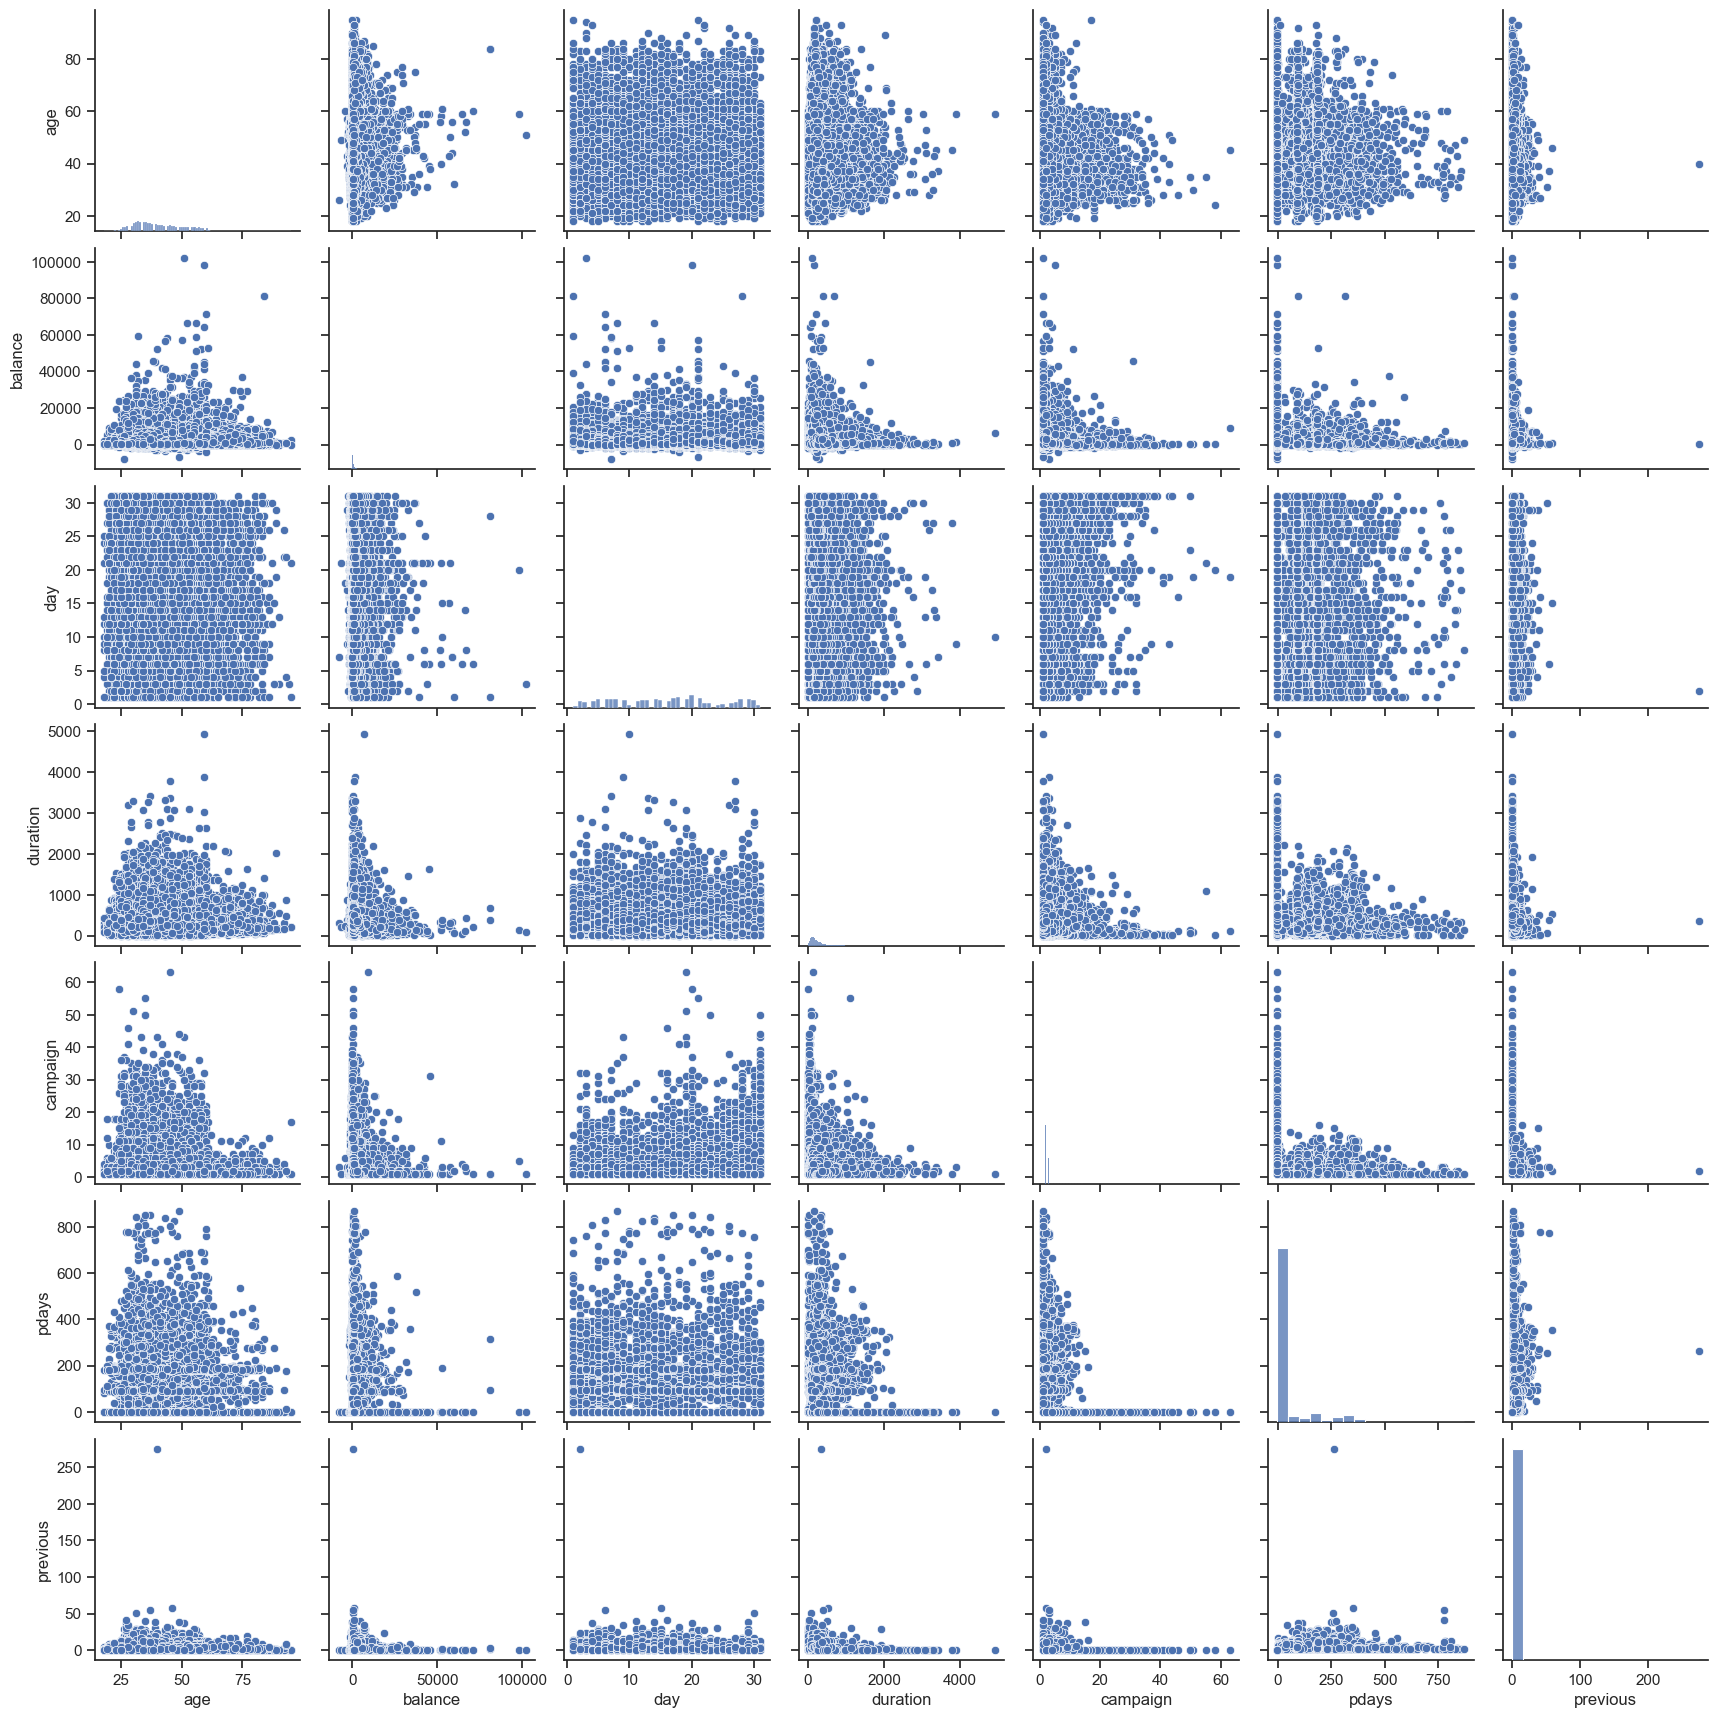

In [36]:
sns.set(style="ticks")

sns.pairplot(data.toPandas())
plt.show()

In [44]:
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|Target|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
| 58|  management| married| tertiary|      0|   2143|      1|   0|unknown|  5|  may|     261|       1|   -1|       0| unknown|     0|
| 44|  technician|  single|secondary|      0|     29|      1|   0|unknown|  5|  may|     151|       1|   -1|       0| unknown|     0|
| 33|entrepreneur| married|secondary|      0|      2|      1|   1|unknown|  5|  may|      76|       1|   -1|       0| unknown|     0|
| 47| blue-collar| married|  unknown|      0|   1506|      1|   0|unknown|  5|  may|      92|       1|   -1|       0| unknown|     0|
| 33|     unknown|  single|  unknown|      0|      1|      0| 

c:\Users\andru\anaconda3\lib\socket.py:775: ResourceWarning: unclosed <socket.socket fd=3680, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 55430), raddr=('127.0.0.1', 55429)>
  self._sock = None


[Text(0.5, 0, 'job'), Text(0, 0.5, 'Target')]

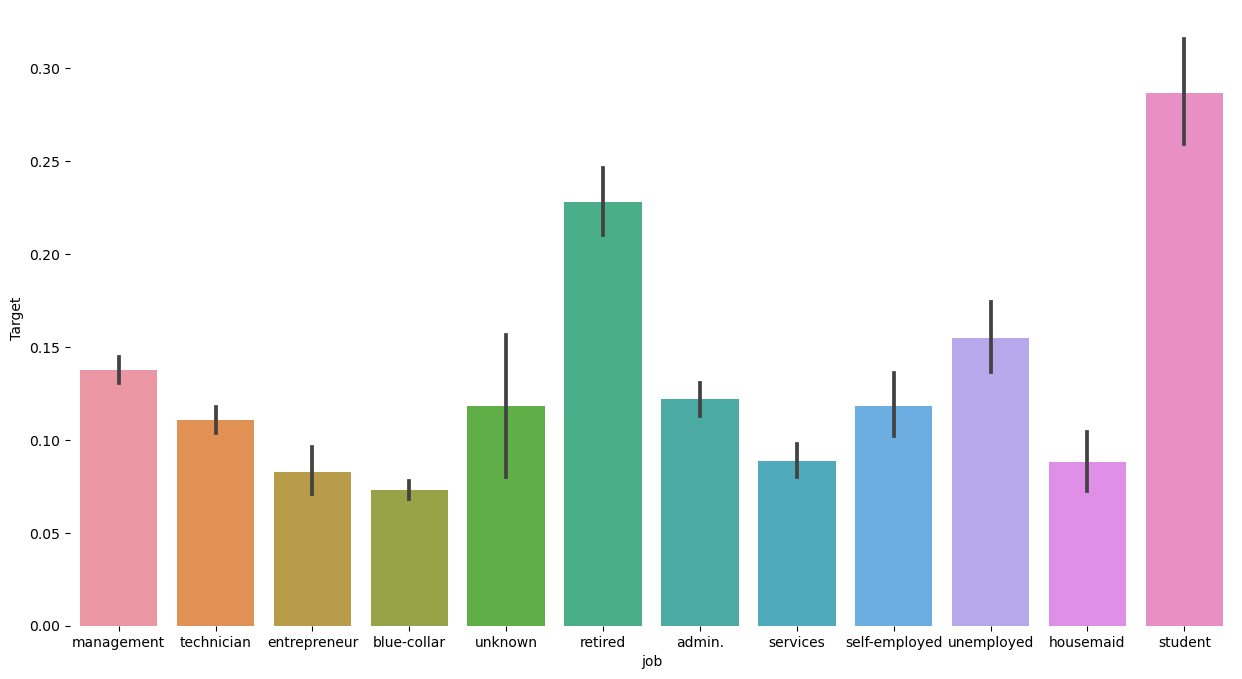

In [46]:
f, ax = plt.subplots(figsize = (15,8)) 
sns.barplot(x="job", y = "Target", data = df.toPandas())
sns.despine(left = True, bottom = True)
ax.set(xlabel='job', ylabel='Target')

c:\Users\andru\anaconda3\lib\socket.py:775: ResourceWarning: unclosed <socket.socket fd=3356, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 55440), raddr=('127.0.0.1', 55439)>
  self._sock = None


[Text(0.5, 0, 'marital'), Text(0, 0.5, 'Target')]

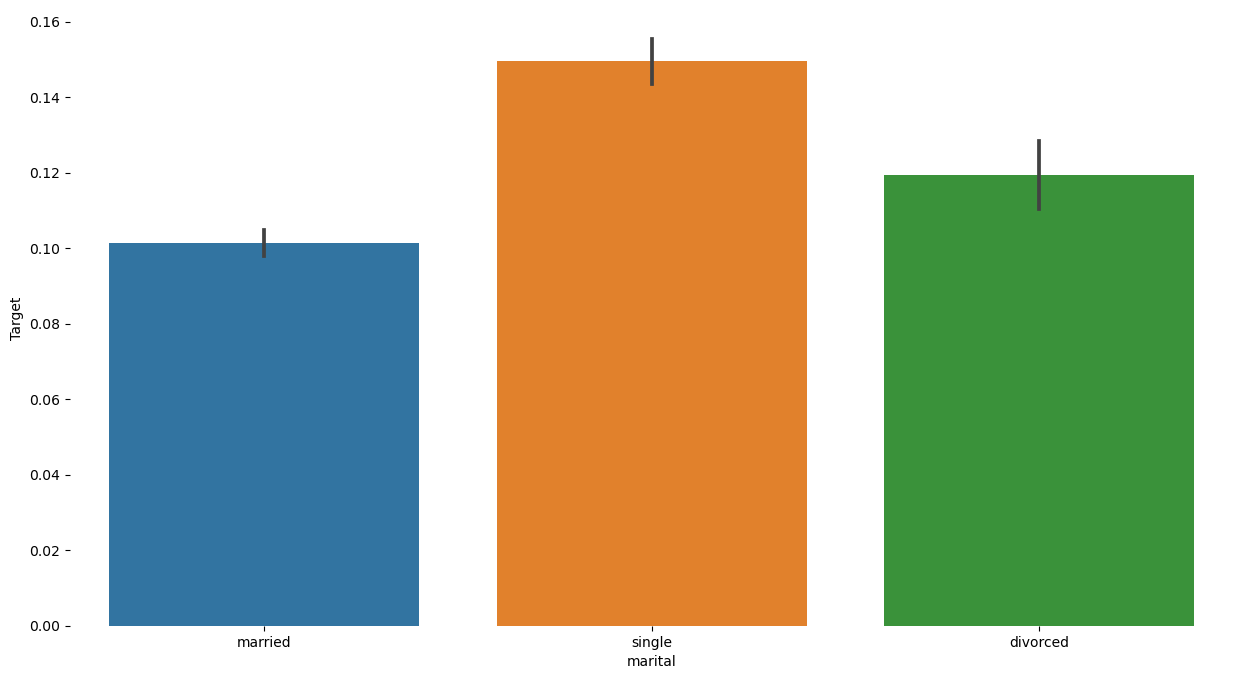

In [48]:
f, ax = plt.subplots(figsize = (15,8)) 
sns.barplot(x="marital", y = "Target", data = df.toPandas())
sns.despine(left = True, bottom = True)
ax.set(xlabel='marital', ylabel='Target')

c:\Users\andru\anaconda3\lib\socket.py:775: ResourceWarning: unclosed <socket.socket fd=3720, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 55450), raddr=('127.0.0.1', 55449)>
  self._sock = None


[Text(0.5, 0, 'education'), Text(0, 0.5, 'Target')]

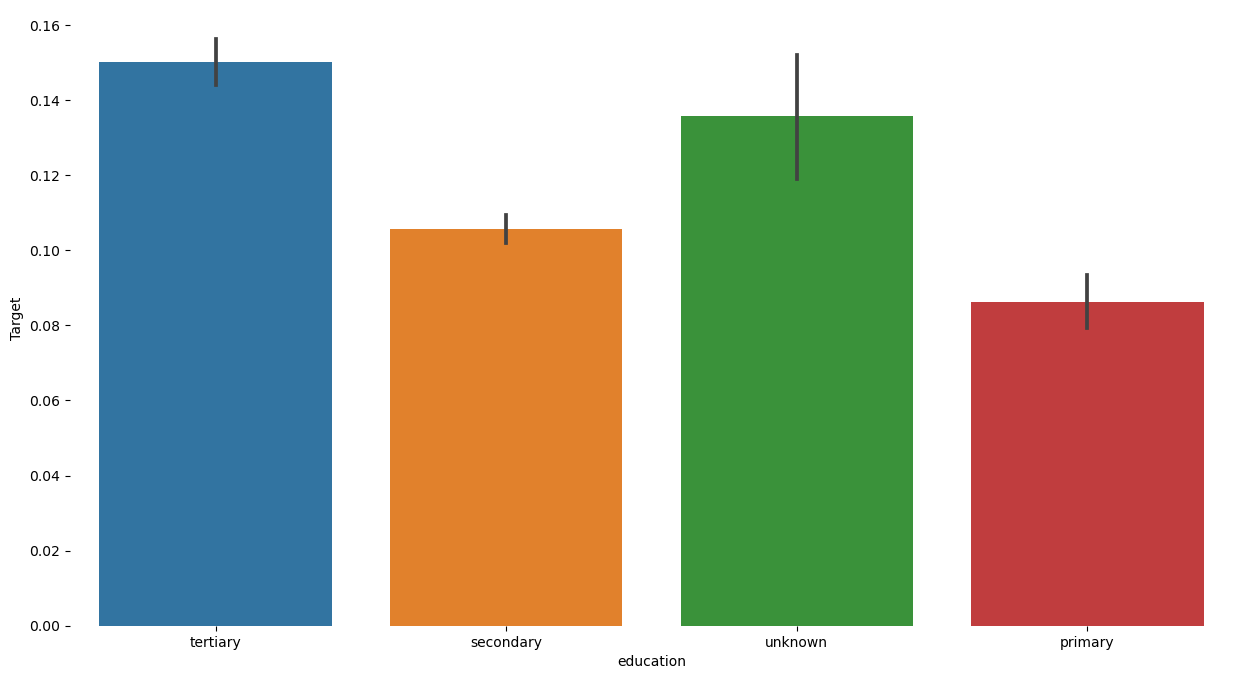

In [49]:
f, ax = plt.subplots(figsize = (15,8)) 
sns.barplot(x="education", y = "Target", data = df.toPandas())
sns.despine(left = True, bottom = True)
ax.set(xlabel='education', ylabel='Target')

c:\Users\andru\anaconda3\lib\socket.py:775: ResourceWarning: unclosed <socket.socket fd=3648, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 55455), raddr=('127.0.0.1', 55454)>
  self._sock = None


[Text(0.5, 0, 'housing'), Text(0, 0.5, 'Target')]

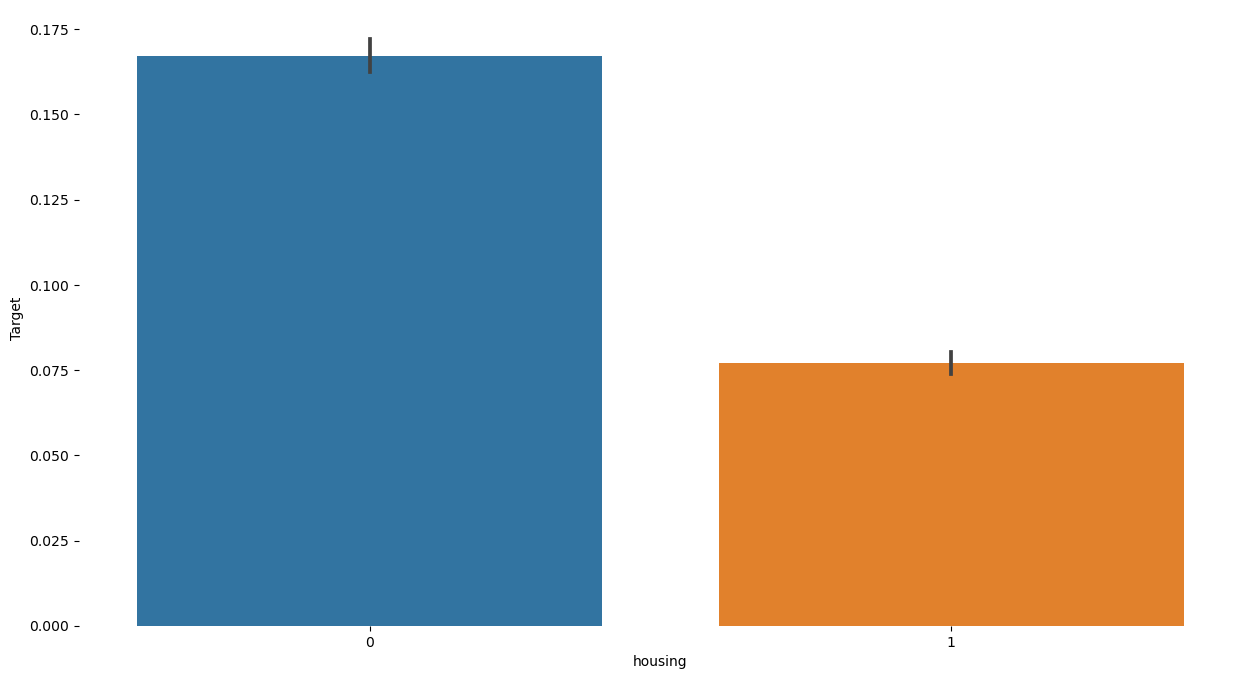

In [50]:
f, ax = plt.subplots(figsize = (15,8)) 
sns.barplot(x="housing", y = "Target", data = df.toPandas())
sns.despine(left = True, bottom = True)
ax.set(xlabel='housing', ylabel='Target')

In [51]:
df.toPandas()

c:\Users\andru\anaconda3\lib\socket.py:775: ResourceWarning: unclosed <socket.socket fd=3656, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 55460), raddr=('127.0.0.1', 55459)>
  self._sock = None


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,nov,508,4,-1,0,unknown,0


In [52]:
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|Target|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------+
| 58|  management| married| tertiary|      0|   2143|      1|   0|unknown|  5|  may|     261|       1|   -1|       0| unknown|     0|
| 44|  technician|  single|secondary|      0|     29|      1|   0|unknown|  5|  may|     151|       1|   -1|       0| unknown|     0|
| 33|entrepreneur| married|secondary|      0|      2|      1|   1|unknown|  5|  may|      76|       1|   -1|       0| unknown|     0|
| 47| blue-collar| married|  unknown|      0|   1506|      1|   0|unknown|  5|  may|      92|       1|   -1|       0| unknown|     0|
| 33|     unknown|  single|  unknown|      0|      1|      0| 

In [53]:
cols = df.columns

***Этот метод включает в себя использование One-Hot Encoder, String Indexer и VectorAssembler, отличительного преобразователя, который объединяет множество столбцов в векторный столбец.
Приведенный ниже код, взятый непосредственно с веб-сайта блока данных, использует StringIndexer для индексации каждого столбца категории, а затем объединяет проиндексированные группы в один зашифрованный параметр. Бинарные траектории добавляются в конец каждой строки в конечном результате. Мы снова используем StringIndexer для кодирования наших меток в индексы меток. После этого VectorAssembler используется для объединения всех столбцов функций в один столбец супервектора.***

In [54]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'Target', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="Subscribed")
stages += [assembler]

***Конвейер: мы используем термин «конвейер» для характеристики нашего метода машинного обучения, который включает объединение в цепочку нескольких генераторов и методов оценки. Ступени конвейера представлены сложной системой.***

In [55]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'Subscribed'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- Subscribed: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: integer (nullable = true)
 |-- loan: integer (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- Target: integer (nullable = true)



In [58]:
df_p = pd.DataFrame(df.take(5), columns=df.columns)

c:\Users\andru\anaconda3\lib\socket.py:775: ResourceWarning: unclosed <socket.socket fd=3344, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 55544), raddr=('127.0.0.1', 55543)>
  self._sock = None


In [75]:
sv = df_p['Subscribed'][1]

SparseVector(42, {2: 1.0, 12: 1.0, 13: 1.0, 17: 1.0, 18: 1.0, 29: 1.0, 32: 44.0, 34: 29.0, 35: 1.0, 37: 5.0, 38: 151.0, 39: 1.0, 40: -1.0})

***Train and Test Split***

In [77]:
train, test = df.randomSplit([0.8, 0.2], seed = 2022)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 36061
Test Dataset Count: 9150


***Logistic Regression***

In [78]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'Subscribed', labelCol = 'label', maxIter=15)
lrModel = lr.fit(train)

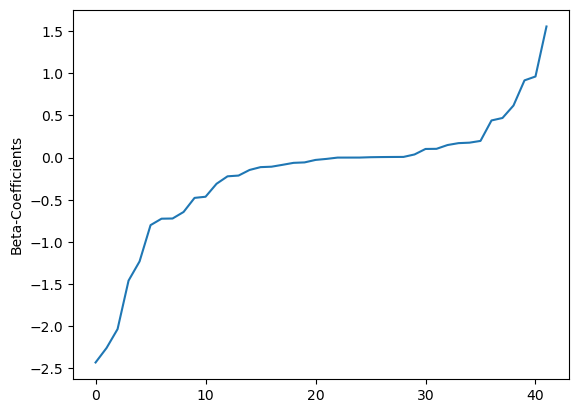

In [79]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta-Coefficients')
plt.show()

c:\Users\andru\anaconda3\lib\socket.py:775: ResourceWarning: unclosed <socket.socket fd=3804, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 55628), raddr=('127.0.0.1', 55627)>
  self._sock = None


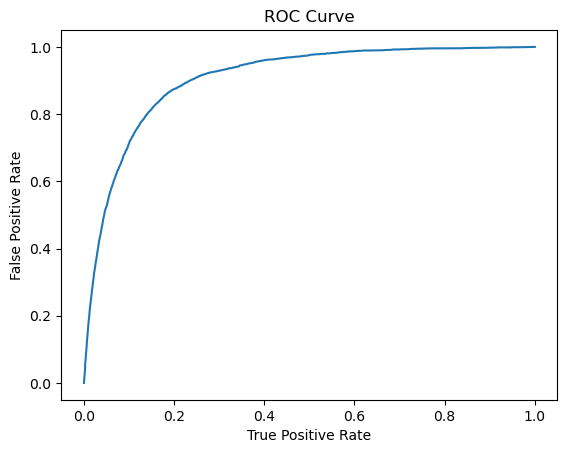

Training set areaUnderROC: 0.9065897716294987


In [81]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


c:\Users\andru\anaconda3\lib\socket.py:775: ResourceWarning: unclosed <socket.socket fd=3808, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 55631), raddr=('127.0.0.1', 55630)>
  self._sock = None


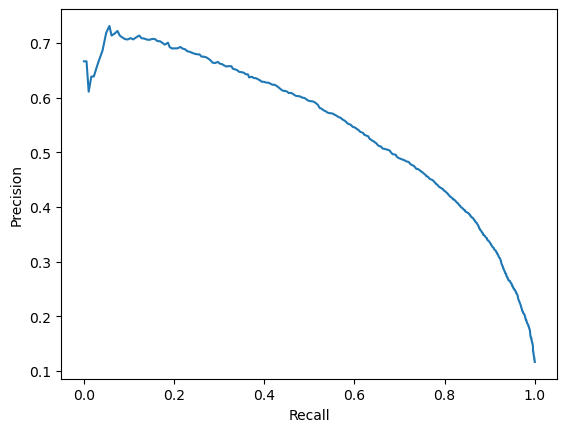

In [82]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [89]:
predictions = lrModel.transform(test)
predictions.filter((F.col('prediction') == 1))\
    .show(20, True)

+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------+--------------------+--------------------+----------+
|label|          Subscribed|age|        job|marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|Target|       rawPrediction|         probability|prediction|
+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------+--------------------+--------------------+----------+
|  0.0|(42,[0,11,13,16,1...| 36|blue-collar|married|secondary|      0|    195|      1|   1| cellular|  7|  may|    1297|       2|   -1|       0| unknown|     0|[-0.9348452366197...|[0.28194275576627...|       1.0|
|  0.0|(42,[0,11,13,16,1...| 27|blue-collar|married|secondary|      0|   1295|      1|   0| cellular| 14|  may|    1106|       1|   -1|       0|

In [88]:
predictions.filter((F.col('prediction') == 1.0))\
    .count()

573

In [90]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9122801993241221


***Decision Tree Classifier***

In [91]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'Subscribed', labelCol = 'label', maxDepth= 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.filter((F.col('prediction') == 1.0))\
    .show()

+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------+-------------+--------------------+----------+
|label|          Subscribed|age|        job|marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|Target|rawPrediction|         probability|prediction|
+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------+-------------+--------------------+----------+
|  0.0|(42,[0,11,13,16,1...| 36|blue-collar|married|secondary|      0|    195|      1|   1| cellular|  7|  may|    1297|       2|   -1|       0| unknown|     0|[471.0,679.0]|[0.40956521739130...|       1.0|
|  0.0|(42,[0,11,13,16,1...| 27|blue-collar|married|secondary|      0|   1295|      1|   0| cellular| 14|  may|    1106|       1|   -1|       0| unknown|     0|[471.0,679.0

In [92]:
predictions.filter((F.col('prediction') == 1.0))\
    .count()

286

In [93]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.3208432999944541


***Random Forest Classifier***

In [94]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'Subscribed', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.filter((F.col('prediction') == 1.0))\
    .show()

+-----+--------------------+---+-----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------+--------------------+--------------------+----------+
|label|          Subscribed|age|        job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|Target|       rawPrediction|         probability|prediction|
+-----+--------------------+---+-----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------+--------------------+--------------------+----------+
|  0.0|(42,[10,12,16,27,...| 24|    student|  single|  unknown|      0|    358|      0|   0| cellular| 14|  sep|     407|       2|   92|       2| success|     0|[9.27095637362311...|[0.46354781868115...|       1.0|
|  1.0|(42,[0,11,15,16,2...| 43|blue-collar| married|  primary|      0|   3917|      0|   0| cellular|  3|  jun|     725|       2|   93|    

In [95]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions)))

Test Area Under ROC: 0.8842347308933312


***Gradient-Boosted Tree Classifier***

In [96]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'Subscribed', labelCol = 'label', maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.filter((F.col('prediction') == 1.0))\
    .show()

+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------+--------------------+--------------------+----------+
|label|          Subscribed|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|Target|       rawPrediction|         probability|prediction|
+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------+--------------------+--------------------+----------+
|  0.0|(42,[0,11,13,16,1...| 36|blue-collar|married|secondary|      0|    195|      1|   1|cellular|  7|  may|    1297|       2|   -1|       0| unknown|     0|[-0.1789009538176...|[0.41149176606648...|       1.0|
|  0.0|(42,[0,11,13,16,1...| 27|blue-collar|married|secondary|      0|   1295|      1|   0|cellular| 14|  may|    1106|       1|   -1|       0| unkn

In [103]:
predictions.show()

+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------+--------------------+--------------------+----------+
|label|          Subscribed|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|Target|       rawPrediction|         probability|prediction|
+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------+--------------------+--------------------+----------+
|  0.0|(42,[0,11,13,16,1...| 48|blue-collar|married|secondary|      1|      0|      1|   1|cellular|  7|  may|     275|       1|   -1|       0| unknown|     0|[3.13785523542612...|[0.95842750819995...|       0.0|
|  0.0|(42,[0,11,13,16,1...| 30|blue-collar|married|secondary|      0|   -109|      1|   1|cellular|  7|  may|     160|       4|   -1|       0| unkn

In [97]:
predictions.filter((F.col('prediction') == 1.0))\
    .count()

663

In [98]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions)))


Test Area Under ROC: 0.9124320289621853


***Modifying this model with the ParamGridBuilder as well as the CrossValidator because the Logistic Regression produced the best results***

In [104]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder().addGrid(lr.maxIter, [500]) 
                                .addGrid(lr.regParam, [0]) 
                                .addGrid(lr.elasticNetParam, [1]) 
                                .build())
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

c:\Users\andru\anaconda3\lib\multiprocessing\pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.ThreadPool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


0.912823308485996

In [105]:
predictions.show()

+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------+--------------------+--------------------+----------+
|label|          Subscribed|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|Target|       rawPrediction|         probability|prediction|
+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------+--------------------+--------------------+----------+
|  0.0|(42,[0,11,13,16,1...| 48|blue-collar|married|secondary|      1|      0|      1|   1|cellular|  7|  may|     275|       1|   -1|       0| unknown|     0|[3.13785523542612...|[0.95842750819995...|       0.0|
|  0.0|(42,[0,11,13,16,1...| 30|blue-collar|married|secondary|      0|   -109|      1|   1|cellular|  7|  may|     160|       4|   -1|       0| unkn

In [102]:
predictions.count()

9150